In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import pathlib
import os
from scipy.stats import pearsonr
import seaborn as sb
from preprocessing_sequencing import preprocess_sequences as ps
from matplotlib import rcParams
import statistics
from final_processing import final_processing_functions as fpf
import ast
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from lcm_registration import lcm_registration_functions as lrf
from decimal import Decimal
from matplotlib.colors import LogNorm, Normalize
import nrrd
import matplotlib.colors as mcolors
from bg_atlasapi import BrainGlobeAtlas
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=True)

%matplotlib inline

In [2]:
#load section npy file
section = '31'
tube = '138'
mouse = 'FIAA45.6d'

#load ROI mask

In [3]:
parameters_path = (f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
parameters = lrf.load_parameters(directory=parameters_path)
lcm_directory = parameters["lcm_directory"]
annotation_data = nrrd.read(parameters["allen_annotation_path"])
ROI_path = pathlib.Path(lcm_directory) / "rois"
reg_dir = pathlib.Path(lcm_directory) / "allenccf/allen_ccf_coord"
[xa, ya, za, one] = np.load(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM/allenccf/allen_ccf_coord/allen_ccf_converted_S0{section}.npy')
roi = plt.imread(f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM/rois/S0{section}_TUBE{tube}.png")
allen_anno = np.array(annotation_data)
annotation = allen_anno[0]

In [4]:
empty_frame = np.zeros((528, 320, 456))
pixcoord = []
for i, axis in enumerate(
    [xa, ya, za]
):
    pixel = np.array(np.round(axis / 25), dtype=int)
    pixel[pixel < 0] = 0
    pixel[pixel >= empty_frame.shape[i]] = 0
    pixcoord.append(pixel)
    
new_one = np.zeros(roi.shape)
for i in np.argwhere(roi== 1):
    x = pixcoord[0][i[0], i[1]]
    y = pixcoord[1][i[0], i[1]]
    z = pixcoord[2][i[0], i[1]]
    if x != 0 and y != 0 and z != 0:
                        #don't include ROI regions that are outside the brain
       new_one[i[0], i[1]] = annotation[int(x), int(y), int(z)]
       
convert_dict = {}
unique_orig = np.unique(new_one[new_one != 0])
for x in unique_orig:
    convert_dict[x] = int(bg_atlas.structures[fpf.get_id(x)]['id'])
   
converted_roi = np.zeros(roi.shape)
for i in np.argwhere(roi== 1):
    if new_one[i[0], i[1]] != 0:
        converted_roi[i[0], i[1]] = convert_dict[new_one[i[0], i[1]]] 
color_dict = {}
unique_converted = np.unique(converted_roi)
for i, x in enumerate(unique_converted):
    color_dict[x] = i
    
color_roi = np.zeros(roi.shape)
for i in np.argwhere(roi== 1):
    if new_one[i[0], i[1]] != 0:
        color_roi[i[0], i[1]] = color_dict[converted_roi[i[0], i[1]]]

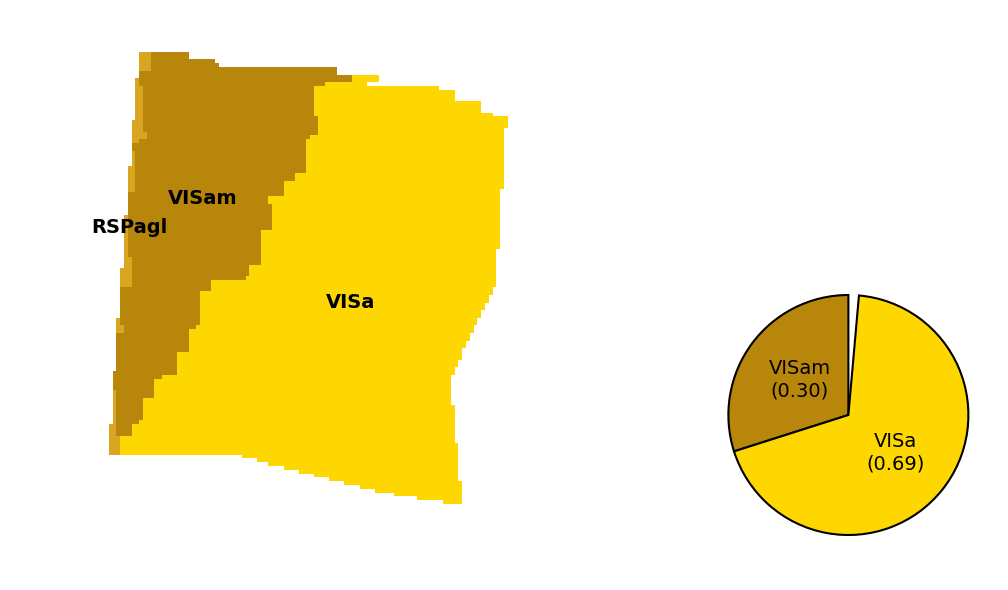

In [52]:

# Define the custom colors for the colormap
custom_colors = ['white', 'darkgoldenrod', 'goldenrod', 'gold']

# Create color mapping for imshow using color_dict
color_roi = np.zeros_like(converted_roi)  # Initialize color_roi with the same shape as converted_roi
for val, color_idx in color_dict.items():
    color_roi[converted_roi == val] = color_idx

# Create a ListedColormap with the custom colors
new_cmap = mcolors.ListedColormap(custom_colors)

# Set up the figure with GridSpec to have more control over layout
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[4, 1])
ax1 = fig.add_subplot(gs[:, 0])  # Main plot on the left, spanning both rows

# --- Plot the imshow on the first axis ---
# Ensure correct normalization with vmin and vmax matching the indices
ax1.imshow(color_roi[100:250, 900:1100], cmap=new_cmap, norm=mcolors.Normalize(vmin=0, vmax=len(color_dict) - 1))
ax1.set_xticks([])
ax1.set_yticks([])

# Annotate the plot with labels
unique_values, counts = np.unique(converted_roi[converted_roi != 0], return_counts=True)
for value in unique_values:
    # Find coordinates where the value occurs
    coords = np.argwhere(converted_roi[100:250, 900:1100] == value)
    
    # Calculate the center of these coordinates
    if coords.size > 0:
        center = coords.mean(axis=0)
        # Annotate the plot with labels
        ax1.text(center[1], center[0], fpf.get_id(value), color='black', ha='center', va='center', fontsize=14, fontweight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)

# --- Plot the pie chart on a new axis ---
# Create a new axes manually at the desired position
ax2 = fig.add_axes([0.6, 0.05, 0.3, 0.5])  # [left, bottom, width, height]

# Calculating fractions
fractions = counts / counts.sum()
labels = [fpf.get_id(x) for x in unique_values]  # Example labels from fpf.get_id(x)

# Define a threshold
threshold = 0.05

# Filter data to include only fractions >= 0.05
included_fractions = fractions >= threshold
filtered_fractions = fractions[included_fractions]
filtered_labels = np.array(labels)[included_fractions]
filtered_values = unique_values[included_fractions]

# Get colors for the pie chart using the color_dict
colors = [custom_colors[color_dict[val]] for val in filtered_values]

# Plot the pie chart without the "Excluded" group
wedges, _ = ax2.pie(
    filtered_fractions,
    startangle=90,
    wedgeprops=dict(edgecolor='black', linewidth=1.5),  # Add border to each slice
    colors=colors, radius=1  # Apply the custom colors based on the color_dict
)

# Add labels inside the segments with fractions
for i, wedge in enumerate(wedges):
    # Get the center angle of each wedge
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
    x = wedge.r / 2 * np.cos(np.deg2rad(angle))
    y = wedge.r / 2 * np.sin(np.deg2rad(angle))
    
    # Annotate the pie chart with labels and fractions
    ax2.text(x, y, f"{filtered_labels[i]}\n({filtered_fractions[i]:.2f})", ha='center', va='center', fontsize=14)

# Set aspect and remove axis for pie chart
ax2.set_aspect('equal')
ax2.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


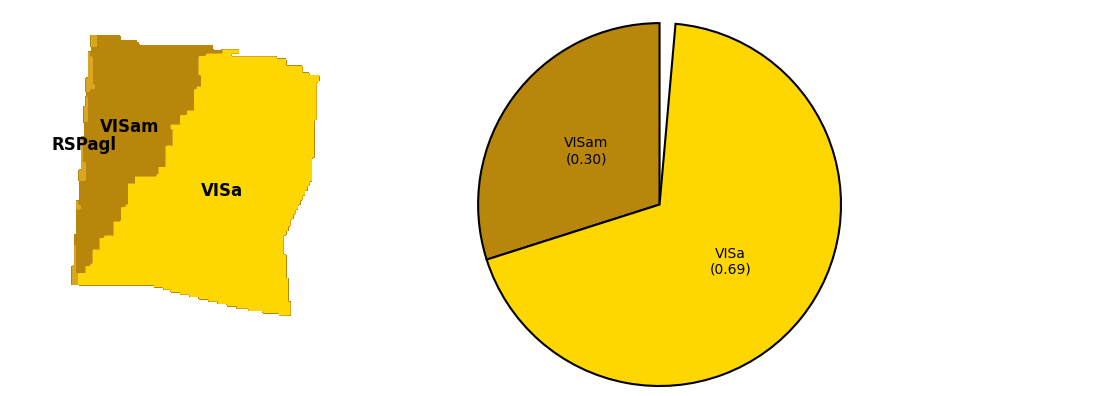

In [32]:
custom_colors = ['white', 'darkgoldenrod', 'goldenrod', 'gold']

# Create color mapping for imshow using color_dict
for val, color_idx in color_dict.items():
    color_roi[converted_roi == val] = color_idx

# Create a ListedColormap with the custom colors
new_cmap = mcolors.ListedColormap(custom_colors)

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.3, top=0.8)  # Adjust space between subplots and top margin

# --- Plot the imshow on the first axis ---
# Ensure correct normalization with vmin and vmax matching the indices
ax1.imshow(color_roi[100:250, 900:1100], cmap=new_cmap, norm=mcolors.Normalize(vmin=0, vmax=len(color_dict) - 1))
ax1.set_xticks([])
ax1.set_yticks([])

# Annotate the plot with labels
unique_values, counts = np.unique(converted_roi[converted_roi != 0], return_counts=True)
for value in unique_values:
    # Find coordinates where the value occurs
    coords = np.argwhere(converted_roi[100:250, 900:1100] == value)
    
    # Calculate the center of these coordinates
    if coords.size > 0:
        center = coords.mean(axis=0)
        # Annotate the plot with 'x' at the center
        ax1.text(center[1], center[0], fpf.get_id(value), color='black', ha='center', va='center', fontsize=12, fontweight='bold')

for spine in ax1.spines.values():
    spine.set_visible(False)
# --- Plot the pie chart on the second axis ---

# Calculating fractions
fractions = counts / counts.sum()
labels = [fpf.get_id(x) for x in unique_values]  # Example labels from fpf.get_id(x)

# Define a threshold
threshold = 0.05

# Filter data to include only fractions >= 0.05
included_fractions = fractions >= threshold
filtered_fractions = fractions[included_fractions]
filtered_labels = np.array(labels)[included_fractions]
filtered_values = unique_values[included_fractions]

# Get colors for the pie chart using the color_dict
colors = [custom_colors[color_dict[val]] for val in filtered_values]

# Plot the pie chart without the "Excluded" group
wedges, _ = ax2.pie(
    filtered_fractions,
    startangle=90,
    wedgeprops=dict(edgecolor='black', linewidth=1.5),  # Add border to each slice
    colors=colors, radius=1  # Apply the custom colors based on the color_dict
)

# Add labels inside the segments with fractions
for i, wedge in enumerate(wedges):
    # Get the center angle of each wedge
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
    x = wedge.r / 2 * np.cos(np.deg2rad(angle))
    y = wedge.r / 2 * np.sin(np.deg2rad(angle))
    
    # Annotate the pie chart with labels and fractions
    ax2.text(x, y, f"{filtered_labels[i]}\n({filtered_fractions[i]:.2f})", ha='center', va='center', fontsize=10)

ax2.set_ylim(-0.2, 0.4)  
ax2.set_xlim(-0.2, 2.4)  

# Display the plots
plt.show()

In [72]:
unique_converted

array([0.00000000e+00, 3.94000000e+02, 8.94000000e+02, 3.12782546e+08])

In [73]:
unique_values, counts = np.unique(converted_roi[converted_roi != 0], return_counts=True)

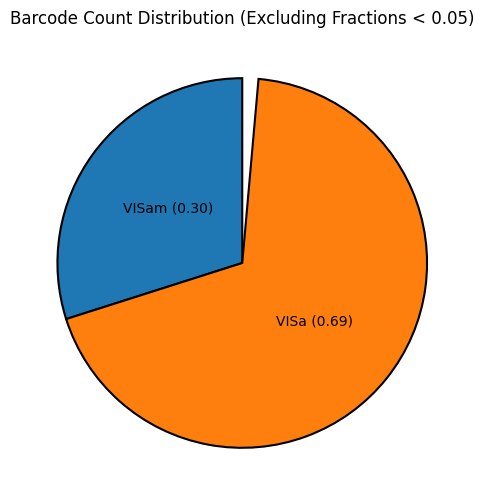

In [22]:
fractions = counts / counts.sum()
labels = [fpf.get_id(x) for x in unique_values]  # Example labels from fpf.get_id(x)

threshold = 0.05

# Filter data to include only fractions >= 0.05
included_fractions = fractions >= threshold
filtered_fractions = fractions[included_fractions]
filtered_labels = np.array(labels)[included_fractions]

# Plot the pie chart without the "Excluded" group
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(
    filtered_fractions, 
    startangle=90, 
    wedgeprops=dict(edgecolor='black', linewidth=1.5)  # Add border to each slice
)

# Add labels inside the segments with fractions
for i, wedge in enumerate(wedges):
    # Get the center angle of each wedge
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
    x = wedge.r / 2 * np.cos(np.deg2rad(angle))
    y = wedge.r / 2 * np.sin(np.deg2rad(angle))
    
    # Annotate the pie chart with labels and fractions
    ax.text(x, y, f"{filtered_labels[i]} ({filtered_fractions[i]:.2f})", ha='center', va='center', fontsize=10)

# Add a title to explain the exclusion of fractions < 0.05
plt.title("Barcode Count Distribution (Excluding Fractions < 0.05)")
plt.show()

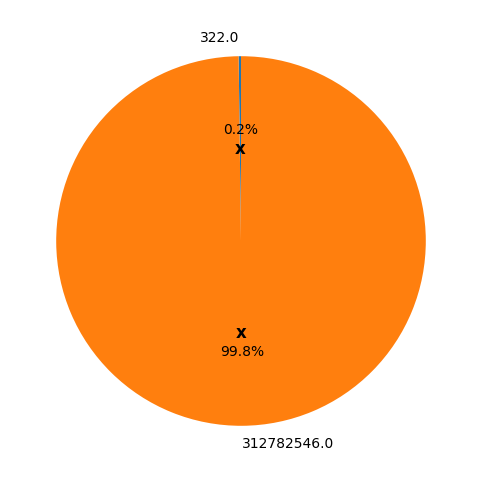

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(counts, labels=unique_values, autopct='%1.1f%%', startangle=90)

# Annotate the center of each pie chart chunk with 'x'
for wedge in wedges:
    # Get the angle and radius of the wedge's center
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
    x = wedge.r * np.cos(np.deg2rad(angle)) / 2
    y = wedge.r * np.sin(np.deg2rad(angle)) / 2
    
    # Annotate with 'x'
    ax.text(x, y, 'x', color='black', ha='center', va='center', fontsize=12, fontweight='bold')

# Show the plot
plt.show()

TypeError: Image data of dtype object cannot be converted to float

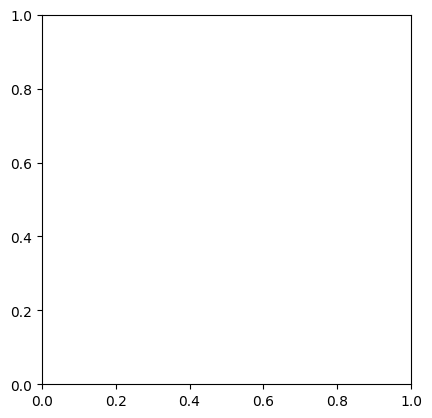

In [88]:

cmap = plt.cm.tab20
cmap.set_under('white')
plt.imshow(converted_array[100:250, 900:1100], cmap=cmap, norm=mcolors.Normalize(vmin=0.1))

In [48]:
list = [fpf.get_id(x) for x in np.unique(new_one)]

In [49]:
list

[None,
 'VISam',
 'VISam',
 'VISam',
 'RSPagl',
 'RSPagl',
 'RSPagl',
 'RSPagl',
 'VISam',
 'VISam',
 'VISa',
 'VISa',
 'VISa',
 'VISa',
 'VISa']

([<matplotlib.patches.Wedge at 0x7f53a0e92af0>,
 [Text(1.0724372276062024, 0.24470061880657898, '281.0'),
  Text(0.9510354845851681, 0.5527490452817219, '401.0'),
  Text(0.7308606368743193, 0.8220965451014038, '433.0'),
  Text(0.5045858561464859, 0.9774421280960413, '671.0'),
  Text(0.48352999253425905, 0.9880277052389875, '774.0'),
  Text(0.4631954555014338, 0.997722391250602, '906.0'),
  Text(0.4404446301032442, 1.0079724836587636, '965.0'),
  Text(0.38941718215868176, 1.0287634607817253, '1046.0'),
  Text(-0.0393284639720368, 1.0992967169611672, '1066.0'),
  Text(-0.6533582018403968, 0.8849424049551946, '312782550.0'),
  Text(-1.0838816945425862, 0.18761788890053113, '312782554.0'),
  Text(-0.9386142314455125, -0.5735881140051194, '312782558.0'),
  Text(-0.1569829201125631, -1.0887407234015511, '312782562.0'),
  Text(0.9570730021501388, -0.5422280595425881, '312782566.0')],
 [Text(0.584965760512474, 0.1334730648035885, '7.1%'),
  Text(0.5187466279555462, 0.3014994792445755, '2.5%'),

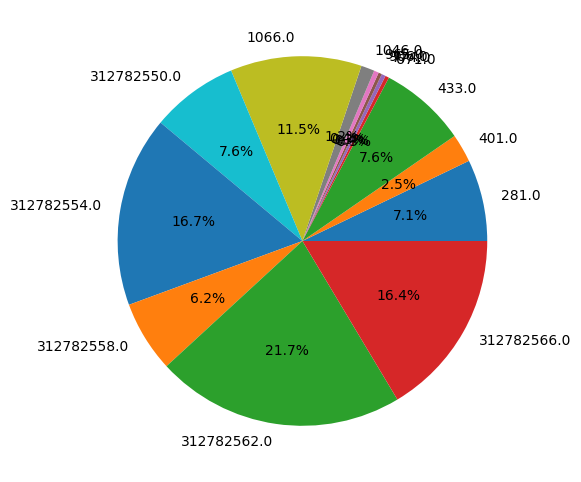

In [36]:
unique_values, counts = np.unique(new_one, return_counts=True)

# Remove the counts of 0
mask = unique_values != 0
filtered_values = unique_values[mask]
filtered_counts = counts[mask]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(filtered_counts, labels=filtered_values, autopct='%1.1f%%')

In [34]:
roi.shape

(1040, 1392)

In [39]:
new_one.shape

(1040, 1392)

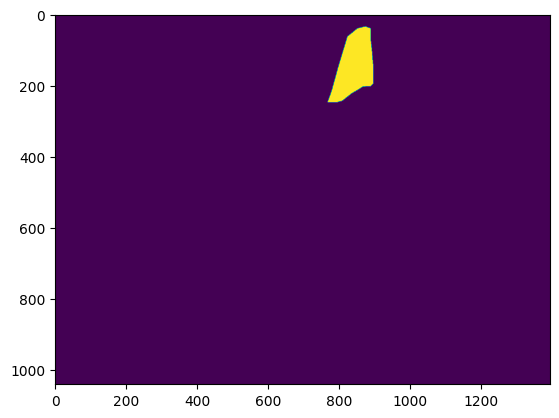

In [31]:
plt.imshow(roi)

In [14]:
new_one = np.zeros(roi.shape)
for x in np.argwhere(roi== 1)
for k in range(pixcoord[0].shape[0]):
    for l in range(pixcoord[0].shape[1]):
        x = new_coord[k, l]
        y = pixcoord[1][k, l]
        z = pixcoord[2][k, l]
        if x != 0 and y != 0 and z != 0:
        #don't include ROI regions that are outside the brain
            if annotation[int(x), int(y), int(z)] != 0
            

PosixPath('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA55.4d/LCM/rois/SO23_TUBE230.tif')

In [11]:
np.load('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA55.4d/LCM/allenccf/allen_ccf_coord/allen_ccf_converted_S023.npy')

array([[[ 4.84787655e+03,  4.84787582e+03,  4.84787510e+03, ...,
          5.04392449e+03,  5.04412492e+03,  5.04432534e+03],
        [ 4.84976811e+03,  4.84976739e+03,  4.84976666e+03, ...,
          5.04575065e+03,  5.04595107e+03,  5.04615150e+03],
        [ 4.85165968e+03,  4.85165895e+03,  4.85165823e+03, ...,
          5.04757680e+03,  5.04777723e+03,  5.04797765e+03],
        ...,
        [ 6.67357179e+03,  6.67372032e+03,  6.67386884e+03, ...,
          6.87291687e+03,  6.87295559e+03,  6.87299431e+03],
        [ 6.67526757e+03,  6.67541609e+03,  6.67556462e+03, ...,
          6.87466614e+03,  6.87470486e+03,  6.87474358e+03],
        [ 6.67696334e+03,  6.67711187e+03,  6.67726039e+03, ...,
          6.87641541e+03,  6.87645413e+03,  6.87649285e+03]],

       [[ 1.48711497e+03,  1.48513910e+03,  1.48316322e+03, ...,
         -2.96798612e+02, -2.97815888e+02, -2.98833163e+02],
        [ 1.49602016e+03,  1.49404428e+03,  1.49206840e+03, ...,
         -2.88227893e+02, -2.89245168e